# Question 1 : pastorales, comédies et tragédies

In [0]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.test.utils import datapath
mallet_path = 'mallet-2.0.8/bin/mallet'

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import philocomp as phc

## Délimitation du corpus

In [0]:
df = pd.read_csv('corpora/all_VER_NOM_ADJqua_ok.csv')

corp = df[df['id_piece'].isin([
                               # Pastorales
                                'BOYER_LISIMENE',
                                'CORNEILLET_BERGEREXTRAVAGANT',
                                'DONNEAUDEVISE_DELIE',
                                'POUSSETDEMONTAUBAN_FELICIE',
                                'QUINAULT_FETESAMOURBACCHUS',
                                'ROTROU_AMARILLIS',
                                'ROTROU_CLEAGENOR',
                                # Comédies
                                'CORNEILLEP_ILLUSIONCOMIQUE',
                                'CORNEILLET_FEINTASTROLOGUE',
                                'DONNEAUDEVISE_EMBARRASDEGODARD',
                                'DONNEAUDEVISE_GENTILHOMMEGUEPIN',
                                'MOLIERE_FOURBERIESDESCAPIN',
                                'QUINAULT_COMEDIESANSCOMEDIE',
                                'ROTROU_SOSIES',
                                'RACINE_PLAIDEURS69',
                                # Tragédies
                                'BOYER_AGAMEMNON',
                                'CORNEILLEP_HORACE',
                                'CORNEILLET_MORTDACHILLE',
                                'DONNEAUDEVISE_AMOURSDUSOLEIL',
                                'POUSSETDEMONTAUBAN_ZENOBIE',
                                'QUINAULT_ATYS',
                                'RACINE_BRITANNICUS',
                                'ROTROU_SAINTGENEST'
                              ])]

# on ne garde que les lignes comprenant au moins 700 lemmes :
corp = corp[corp['nlemmes'] > 700]

# on calcule le nombre de lemmes pour chacun des genres :
pd.pivot_table(corp, index=['genre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

,id_piece,nlemmes
genre,,
Comédie,50,39919
Pastorale,48,38392
Tragédie,60,48000


In [0]:
# on calcule le nombre de lemmes pour chacun des genres et pièces :
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

id_piece  \
genre     titre                                                          
Comédie   L'EMBARRAS DE GODARD, OU L'ACCOUCHÉE, COMÉDIE              3   
          L'ILLUSION COMIQUE, COMÉDIE                                8   
          LA COMÉDIE SANS COMÉDIE, COMÉDIE                           8   
          LE FEINT ASTROLOGUE, COMÉDIE                               9   
          LE GENTILHOMME GUESPIN, COMÉDIE                            3   
          LES FOURBERIES DE SCAPIN, COMÉDIE                          7   
          LES PLAIDEURS, COMÉDIE.                                    4   
          LES SOSIES, COMÉDIE                                        8   
Pastorale AMARILLIS, PASTORALE.                                      6   
          CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                      8   
          DÉLIE, PASTORALE.                                          7   
          LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.                9   
          LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...         8   
          LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE              2   
          LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                    8   
Tragédie  AGAMEMNON, TRAGÉDIE.                                       8   
          ATYS, TRAGÉDIE                                             4   
          BRITANNICUS, TRAGÉDIE                                      8   
          HORACE, TRAGÉDIE                                           8   
          LA MORT D'ACHILLE, TRAGÉDIE                                8   
          LE VÉRITABLE SAINT GENEST, TRAGÉDIE                        8   
          LES AMOURS DU SOLEIL, PASTORALE.                           9   
          ZÉNOBIE REINE D'ARMÉNIE, TRAGÉDIE.                         7   

                                                              nlemmes  
genre     titre                                                        
Comédie   L'EMBARRAS DE GODARD, OU L'ACCOUCHÉE, COMÉDIE          2400  
          L'ILLUSION COMIQUE, COMÉDIE                            6400  
          LA COMÉDIE SANS COMÉDIE, COMÉDIE                       6400  
          LE FEINT ASTROLOGUE, COMÉDIE                           7172  
          LE GENTILHOMME GUESPIN, COMÉDIE                        2400  
          LES FOURBERIES DE SCAPIN, COMÉDIE                      5547  
          LES PLAIDEURS, COMÉDIE.                                3200  
          LES SOSIES, COMÉDIE                                    6400  
Pastorale AMARILLIS, PASTORALE.                                  4800  
          CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                  6400  
          DÉLIE, PASTORALE.                                      5592  
          LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.            7200  
          LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...     6400  
          LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE          1600  
          LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                6400  
Tragédie  AGAMEMNON, TRAGÉDIE.                                   6400  
          ATYS, TRAGÉDIE                                         3200  
          BRITANNICUS, TRAGÉDIE                                  6400  
          HORACE, TRAGÉDIE                                       6400  
          LA MORT D'ACHILLE, TRAGÉDIE                            6400  
          LE VÉRITABLE SAINT GENEST, TRAGÉDIE                    6400  
          LES AMOURS DU SOLEIL, PASTORALE.                       7200  
          ZÉNOBIE REINE D'ARMÉNIE, TRAGÉDIE.                     5600

On constate un certain déséquilibre (beaucoup plus de tragédies que de pastorales et de comédies, des pièces de longueurs beaucoup plus importante que d'autres). On exporte donc le corpus pour pouvoir le retravailler dans un tableur.

In [0]:
corp.to_excel("corpora/corpus1.xlsx", index=False)

On corrige les déséquilibres (au moins pour la répartition entre genres) en supprimant quelques lignes pour les tragédies et comédies, puis on réimporte le corpus.

In [0]:
corp = pd.read_csv("corpora/corpus1_eq.csv")

In [0]:
On refait ensuite les calculs de répartitions exécutés précedemment.

In [0]:
pd.pivot_table(corp, index=['genre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

,id_piece,nlemmes
genre,,
Comédie,47,37519
Pastorale,47,37592
Tragédie,47,37600


In [0]:
pd.pivot_table(corp, index=['genre', 'titre'],
               values=['nlemmes', 'id_piece'],
               aggfunc={'nlemmes': np.sum,
                        'id_piece': 'count'})

id_piece  \
genre     titre                                                          
Comédie   L'EMBARRAS DE GODARD, OU L'ACCOUCHÉE, COMÉDIE              3   
          L'ILLUSION COMIQUE, COMÉDIE                                7   
          LA COMÉDIE SANS COMÉDIE, COMÉDIE                           8   
          LE FEINT ASTROLOGUE, COMÉDIE                               8   
          LE GENTILHOMME GUESPIN, COMÉDIE                            3   
          LES FOURBERIES DE SCAPIN, COMÉDIE                          7   
          LES PLAIDEURS, COMÉDIE.                                    4   
          LES SOSIES, COMÉDIE                                        7   
Pastorale AMARILLIS, PASTORALE.                                      6   
          CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                      8   
          DÉLIE, PASTORALE.                                          7   
          LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.                8   
          LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...         8   
          LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE              2   
          LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                    8   
Tragédie  AGAMEMNON, TRAGÉDIE.                                       6   
          ATYS, TRAGÉDIE                                             4   
          BRITANNICUS, TRAGÉDIE                                      7   
          HORACE, TRAGÉDIE                                           6   
          LA MORT D'ACHILLE, TRAGÉDIE                                6   
          LE VÉRITABLE SAINT GENEST, TRAGÉDIE                        6   
          LES AMOURS DU SOLEIL, PASTORALE.                           6   
          ZÉNOBIE REINE D'ARMÉNIE, TRAGÉDIE.                         6   

                                                              nlemmes  
genre     titre                                                        
Comédie   L'EMBARRAS DE GODARD, OU L'ACCOUCHÉE, COMÉDIE          2400  
          L'ILLUSION COMIQUE, COMÉDIE                            5600  
          LA COMÉDIE SANS COMÉDIE, COMÉDIE                       6400  
          LE FEINT ASTROLOGUE, COMÉDIE                           6372  
          LE GENTILHOMME GUESPIN, COMÉDIE                        2400  
          LES FOURBERIES DE SCAPIN, COMÉDIE                      5547  
          LES PLAIDEURS, COMÉDIE.                                3200  
          LES SOSIES, COMÉDIE                                    5600  
Pastorale AMARILLIS, PASTORALE.                                  4800  
          CLÉAGÉNOR et DORISTÉE, TRAGI-COMÉDIE.                  6400  
          DÉLIE, PASTORALE.                                      5592  
          LE BERGER EXTRAVAGANT, PASTORALE BURLESQUE.            6400  
          LES CHARMES DE FÉLICIE, TIRÉS DE LA DIANE DE MO...     6400  
          LES FÊTES DE L'AMOUR ET DE BACCHUS, PASTORALE          1600  
          LISIMÈNE OU LA JEUNE BERGÈRE, PASTORALE                6400  
Tragédie  AGAMEMNON, TRAGÉDIE.                                   4800  
          ATYS, TRAGÉDIE                                         3200  
          BRITANNICUS, TRAGÉDIE                                  5600  
          HORACE, TRAGÉDIE                                       4800  
          LA MORT D'ACHILLE, TRAGÉDIE                            4800  
          LE VÉRITABLE SAINT GENEST, TRAGÉDIE                    4800  
          LES AMOURS DU SOLEIL, PASTORALE.                       4800  
          ZÉNOBIE REINE D'ARMÉNIE, TRAGÉDIE.                     4800

## Elimination des lemmes les plus fréquents

Le corpus ne comprend que des lemmes de noms (communs ou propres), verbes et adjectifs qualificatifs. On peut donc considérer qu'une partie non négligeable des lemmes les plus fréquents (déterminants, pronoms, adverbes) a été éliminée.
On établit toutefois une liste des lemmes, du plus au moins fréquent, afin de procéder à de nouvelles éliminations.

In [0]:
corp_lemmas = phc.get_lemmas(corp)
corp_lemmas_freq = phc.get_freq_lemmas(corp_lemmas, 30) # 30 correspond à la fréquence cumulée maximale retenue
corp_lemmas_freq

,lemma,freq,cum_freq
0,être,6937,6.154679
1,avoir,4703,10.327297
2,faire,2526,12.568427
3,pouvoir,1755,14.125507
4,voir,1733,15.663067
5,amour,1173,16.703782
6,vouloir,1091,17.671745
7,savoir,1033,18.588248
8,aimer,957,19.437322
9,dire,922,20.255343


Après différents tests, on considère qu'en deçà de 30 % de fréquence cumulée les termes ne sont pas très signifiant pour la constitution des thèmes.

On crée donc une liste de lemmes à exclure à partir de ceux-ci et on les supprime du corpus.

In [0]:
stop_words_list = corp_lemmas_freq['lemma'].to_list()

In [0]:
corp['lemmes_sans_stop_words'] = corp['lemmes'].apply(lambda text: phc.remove_stop_words(text, stop_words_list))
corp['nlemmes_sans_stop_words'] = corp['lemmes_sans_stop_words'].apply(lambda x : len(x.split()))

On vérifie que cette suppression de lemmes ne crée pas un nouveau déséquilibre trop important entre genres.

In [0]:
pd.pivot_table(corp, index=['genre'],
               values=['nlemmes', 'nlemmes_sans_stop_words'],
               aggfunc=np.sum)

,nlemmes,nlemmes_sans_stop_words
genre,,
Comédie,37519,25694
Pastorale,37592,26224
Tragédie,37600,27016


On constate un léger déséquilibre au détriment de la comédie, on ne corrige pas toutefois.

## Extraction des thèmes

On recourt un modèle d'allocation de Dirichlet latente pour l'extraction des thèmes.

On utilise ici l'[API Python](https://radimrehurek.com/gensim/models/wrappers/ldamallet.html) proposée par le module Gensim pour le modèle [LDA MALLET](http://mallet.cs.umass.edu/topics.php).

### Transformation des données

In [0]:
data = corp['lemmes_sans_stop_words'].str.split().to_list()
id2word = corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

### Recherche du nombre de thèmes optimal

On lance des tests entre 2 et 20 thèmes pour obtenir la perplexité et la cohérence et déterminer le meilleur nombre de thèmes.
(Même si, intuitivement, on cherche un modèle à 3 thèmes.)

In [0]:
for k in range(2,21,1):
    mallet_model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                    corpus=corpus,
                                                    id2word=id2word,
                                                    num_topics=k,
                                                    iterations=10,
                                                    random_seed=5
                                                    )
    lda_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"k = {k} : coherence_lda = {coherence_lda}")

k = 2 : coherence_lda = 0.23497644120741243
k = 3 : coherence_lda = 0.22425185030508085
k = 4 : coherence_lda = 0.25212414490588925
k = 5 : coherence_lda = 0.279092299675729
k = 6 : coherence_lda = 0.28291559858443477
k = 7 : coherence_lda = 0.2514408365721042
k = 8 : coherence_lda = 0.25917315551998676
k = 9 : coherence_lda = 0.2663480551978302
k = 10 : coherence_lda = 0.2986873163906989
k = 11 : coherence_lda = 0.28872003680737685
k = 12 : coherence_lda = 0.31103491782038833
k = 13 : coherence_lda = 0.28601867769882416
k = 14 : coherence_lda = 0.31869904965065005
k = 15 : coherence_lda = 0.2938465718117028
k = 16 : coherence_lda = 0.31902041088377686
k = 17 : coherence_lda = 0.3211027648402689
k = 18 : coherence_lda = 0.2982306943190562
k = 19 : coherence_lda = 0.29205413314076223
k = 20 : coherence_lda = 0.3077509027902329


Apparemment, Gensim ne permet pas de récupérer simplement la perplexité pour LDA MALLET.
On retrouve toutefois celle-ci dans les logs de la sortie standard, dont on propose ici une copie simplifiée.
La perplexité correspond à la valeur de 'LL/token'.

Mallet LDA: 2 topics, 1 topic bits, 1 topic mask
<10> LL/token: -8,2754

Mallet LDA: 3 topics, 2 topic bits, 11 topic mask
<10> LL/token: -8,5443

Mallet LDA: 4 topics, 2 topic bits, 11 topic mask
<10> LL/token: -8,70609

Mallet LDA: 5 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,80383

Mallet LDA: 6 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,87875

Mallet LDA: 7 topics, 3 topic bits, 111 topic mask
<10> LL/token: -8,99222

Mallet LDA: 8 topics, 3 topic bits, 111 topic mask
<10> LL/token: -9,06346

Mallet LDA: 9 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,08587

Mallet LDA: 10 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,12088

Mallet LDA: 11 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,14834

Mallet LDA: 12 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,20154

Mallet LDA: 13 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,19874

Mallet LDA: 14 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,24558

Mallet LDA: 15 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,27234

Mallet LDA: 16 topics, 4 topic bits, 1111 topic mask
<10> LL/token: -9,2649

Mallet LDA: 17 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,28069

Mallet LDA: 18 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,29241

Mallet LDA: 19 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,31476

Mallet LDA: 20 topics, 5 topic bits, 11111 topic mask
<10> LL/token: -9,28999

On relance pour 2 valeurs de k différentes : 3 (nombre de thèmes recherchés intuitivement) et 6 (nombre de thèmes qui obtient un bon niveau de cohérence sans être trop élevé et donc rendre l'analyse trop difficile).

### Modèle à 3 sujets

In [0]:
mallet_model3 = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=3,
                                             iterations=20,
                                             random_seed=5
                                            )
lda_model3 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model3)

#### Termes proposés par le modèle

On affiche les termes qui composent les thèmes proposés par le modèle.

In [0]:
phc.print_topics(lda_model3)

Thème : th_01
mots : 0.008*"madame" + 0.007*"laisser" + 0.006*"Dieu" + 0.006*"tenir" + 0.005*"homme" + 0.005*"chose" + 0.005*"plaisir" + 0.005*"lieu" + 0.005*"passer" + 0.005*"bon"

Thème : th_02
mots : 0.010*"mort" + 0.008*"main" + 0.007*"sortir" + 0.007*"hymen" + 0.007*"sang" + 0.006*"gloire" + 0.006*"heureux" + 0.006*"roi" + 0.005*"souffrir" + 0.005*"crime"

Thème : th_03
mots : 0.011*"berger" + 0.009*"amant" + 0.008*"connaître" + 0.007*"plaire" + 0.006*"doux" + 0.006*"esprit" + 0.006*"bergère" + 0.006*"mal" + 0.006*"flamme" + 0.005*"chercher"



On peut envisager les correspondances suivantes :
- thème 1 : tragédie (lexique qui évoque la grandeur et la noblesse),
- thème 2 : comédie (lexique qui évoque davantage des situations et des relations propres à la bourgeoisie du XVIIe s.)
- thème 3 : pastorale (lexique qui évoque à la fois la campagne et les relations amoureuses.

#### Visualisation LDAvis

On poursuit l'interprétation grâce à une visualisation 'LDAvis'.

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model3, corpus, id2word, sort_topics=False)
vis

/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.035635 -0.217643       1        1  31.282267
1     -0.220323  0.080098       2        1  35.508868
2      0.184688  0.137545       3        1  33.208865, topic_info=             Term        Freq       Total Category  logprob  loglift
1093       berger  297.000000  297.000000  Default  30.0000  30.0000
242          mort  322.000000  322.000000  Default  29.0000  29.0000
196         hymen  191.000000  191.000000  Default  28.0000  28.0000
1094      bergère  161.000000  161.000000  Default  27.0000  27.0000
343          sang  192.000000  192.000000  Default  26.0000  26.0000
228        madame  324.000000  324.000000  Default  25.0000  25.0000
24          amant  298.000000  298.000000  Default  24.0000  24.0000
958         homme  146.000000  146.000000  Default  23.0000  23.0000
827         chose  154.000000  154.000000  Default  22.0000  22.0000
1054       plaire  245.000000  245.000000  Default  21.0000  21.0000
535        gloire  208.000000  208.000000  Default  20.0000  20.0000
404         voilà  114.000000  114.000000  Default  19.0000  19.0000
283       plaisir  166.000000  166.000000  Default  18.0000  18.0000
1795         gens   86.000000   86.000000  Default  17.0000  17.0000
2993          Don   91.000000   91.000000  Default  16.0000  16.0000
349      seigneur  241.000000  241.000000  Default  15.0000  15.0000
1312       naître  113.000000  113.000000  Default  14.0000  14.0000
160         femme  141.000000  141.000000  Default  13.0000  13.0000
30          appas  121.000000  121.000000  Default  12.0000  12.0000
167          fils  191.000000  191.000000  Default  11.0000  11.0000
717        esprit  271.000000  271.000000  Default  10.0000  10.0000
810          Dieu  191.000000  191.000000  Default   9.0000   9.0000
117       douleur  164.000000  164.000000  Default   8.0000   8.0000
804        visage   81.000000   81.000000  Default   7.0000   7.0000
87      connaître  306.000000  306.000000  Default   6.0000   6.0000
229          main  296.000000  296.000000  Default   5.0000   5.0000
292        prince   85.000000   85.000000  Default   4.0000   4.0000
99          crime  169.000000  169.000000  Default   3.0000   3.0000
1095          bon  205.000000  205.000000  Default   2.0000   2.0000
1567         Rome  117.000000  117.000000  Default   1.0000   1.0000
1292    emprunter   20.918963   20.918963   Topic1  -7.0736   1.1621
1331        usage   20.918963   20.918963   Topic1  -7.0736   1.1621
946   embarrasser   20.918963   20.918963   Topic1  -7.0736   1.1621
2263       moquer   20.918963   20.918963   Topic1  -7.0736   1.1621
2386          écu   20.918963   20.918963   Topic1  -7.0736   1.1621
1276  accompagner   20.918963   20.918963   Topic1  -7.0736   1.1621
1004      établir   20.918963   20.918963   Topic1  -7.0736   1.1621
65         captif   20.918963   20.918963   Topic1  -7.0736   1.1621
2151    contenter   20.918963   20.918963   Topic1  -7.0736   1.1621
1315       partie   20.918963   20.918963   Topic1  -7.0736   1.1621
636        timide   20.918963   20.918963   Topic1  -7.0736   1.1621
1102     conduite   20.918963   20.918963   Topic1  -7.0736   1.1621
1442         écho   20.918963   20.918963   Topic1  -7.0736   1.1621
2640   incommoder    0.996141    0.996141   Topic1 -10.1181   1.1621
2622        chien   11.953693   11.953693   Topic1  -7.6332   1.1621
2599    Angélique    3.984564    3.984564   Topic1  -8.7318   1.1621
2602        Iphis    0.996141    0.996141   Topic1 -10.1181   1.1621
2655       naïade    0.996141    0.996141   Topic1 -10.1181   1.1621
2609       airain    2.988423    2.988423   Topic1  -9.0195   1.1621
2614    anxaxarte    0.996141    0.996141   Topic1 -10.1181   1.1621
2616       assidu    4.980705    4.980705   Topic1  -8.5087   1.1621
2619      babille    0.996141    0.996141   Topic1 -10.1181   1.1621
2625        corde    7.969129 

#### Nombre de documents par thèmes, genres et pièces

In [0]:
main_topic_by_doc_3 = phc.get_main_topic_by_doc(lda_model3, corpus, corp, "corpus_1_03")
pd.pivot_table(main_topic_by_doc_3, index=['thème', 'genre', 'id_piece'],
               values=['indice_doc'],
               aggfunc='count')

indice_doc
thème genre     id_piece                                   
th_01 Comédie   CORNEILLEP_ILLUSIONCOMIQUE                3
                CORNEILLET_FEINTASTROLOGUE                1
                DONNEAUDEVISE_EMBARRASDEGODARD            2
                DONNEAUDEVISE_GENTILHOMMEGUEPIN           1
                MOLIERE_FOURBERIESDESCAPIN                6
                QUINAULT_COMEDIESANSCOMEDIE               2
                RACINE_PLAIDEURS69                        4
                ROTROU_SOSIES                             2
      Pastorale POUSSETDEMONTAUBAN_FELICIE                6
      Tragédie  DONNEAUDEVISE_AMOURSDUSOLEIL              1
                RACINE_BRITANNICUS                        3
th_02 Comédie   CORNEILLEP_ILLUSIONCOMIQUE                4
                QUINAULT_COMEDIESANSCOMEDIE               2
                ROTROU_SOSIES                             4
      Pastorale BOYER_LISIMENE                            1
                CORNEILLET_BERGEREXTRAVAGANT              2
                POUSSETDEMONTAUBAN_FELICIE                1
                ROTROU_CLEAGENOR                          4
      Tragédie  BOYER_AGAMEMNON                           6
                CORNEILLEP_HORACE                         6
                CORNEILLET_MORTDACHILLE                   6
                DONNEAUDEVISE_AMOURSDUSOLEIL              1
                POUSSETDEMONTAUBAN_ZENOBIE                6
                QUINAULT_ATYS                             4
                RACINE_BRITANNICUS                        4
                ROTROU_SAINTGENEST                        6
th_03 Comédie   CORNEILLET_FEINTASTROLOGUE                7
                DONNEAUDEVISE_EMBARRASDEGODARD            1
                DONNEAUDEVISE_GENTILHOMMEGUEPIN           2
                MOLIERE_FOURBERIESDESCAPIN                1
                QUINAULT_COMEDIESANSCOMEDIE               4
                ROTROU_SOSIES                             1
      Pastorale BOYER_LISIMENE                            7
                CORNEILLET_BERGEREXTRAVAGANT              6
                DONNEAUDEVISE_DELIE                       7
                POUSSETDEMONTAUBAN_FELICIE                1
                QUINAULT_FETESAMOURBACCHUS                2
                ROTROU_AMARILLIS                          6
                ROTROU_CLEAGENOR                          4
      Tragédie  DONNEAUDEVISE_AMOURSDUSOLEIL              4

#### Contribution (en pourcentage) de chaque thème à chacune des pièces classées par genre

In [0]:
topics_contrib_by_doc_3 = phc.get_topics_contrib_by_doc(lda_model3, corpus, corp, "corpus_1_03")
pd.pivot_table(topics_contrib_by_doc_3, index=['genre', 'id_piece'],
               columns=['thème'],
               values=['prc_contribution'],
               aggfunc='mean')

prc_contribution             \
thème                                                th_01      th_02   
genre     id_piece                                                      
Comédie   CORNEILLEP_ILLUSIONCOMIQUE             33.537143  35.932857   
          CORNEILLET_FEINTASTROLOGUE             29.888750  27.488750   
          DONNEAUDEVISE_EMBARRASDEGODARD         43.456667  18.670000   
          DONNEAUDEVISE_GENTILHOMMEGUEPIN        36.696667  16.476667   
          MOLIERE_FOURBERIESDESCAPIN             54.098571  15.741429   
          QUINAULT_COMEDIESANSCOMEDIE            31.232500  27.852500   
          RACINE_PLAIDEURS69                     46.662500  22.627500   
          ROTROU_SOSIES                          32.407143  37.641429   
Pastorale BOYER_LISIMENE                         18.948750  30.903750   
          CORNEILLET_BERGEREXTRAVAGANT           25.216250  30.571250   
          DONNEAUDEVISE_DELIE                    19.870000  22.311429   
          POUSSETDEMONTAUBAN_FELICIE             42.260000  25.567500   
          QUINAULT_FETESAMOURBACCHUS             34.105000  26.620000   
          ROTROU_AMARILLIS                       28.396667  27.191667   
          ROTROU_CLEAGENOR                       28.820000  38.137500   
Tragédie  BOYER_AGAMEMNON                        27.731667  56.686667   
          CORNEILLEP_HORACE                      27.540000  52.805000   
          CORNEILLET_MORTDACHILLE                18.593333  61.076667   
          DONNEAUDEVISE_AMOURSDUSOLEIL           30.978333  26.133333   
          POUSSETDEMONTAUBAN_ZENOBIE             27.093333  50.278333   
          QUINAULT_ATYS                          24.420000  52.020000   
          RACINE_BRITANNICUS                     39.154286  44.404286   
          ROTROU_SAINTGENEST                     34.288333  46.140000   

                                                      
thème                                          th_03  
genre     id_piece                                    
Comédie   CORNEILLEP_ILLUSIONCOMIQUE       30.534286  
          CORNEILLET_FEINTASTROLOGUE       42.623750  
          DONNEAUDEVISE_EMBARRASDEGODARD   37.876667  
          DONNEAUDEVISE_GENTILHOMMEGUEPIN  46.826667  
          MOLIERE_FOURBERIESDESCAPIN       30.160000  
          QUINAULT_COMEDIESANSCOMEDIE      40.917500  
          RACINE_PLAIDEURS69               30.712500  
          ROTROU_SOSIES                    29.951429  
Pastorale BOYER_LISIMENE                   50.148750  
          CORNEILLET_BERGEREXTRAVAGANT     44.210000  
          DONNEAUDEVISE_DELIE              57.818571  
          POUSSETDEMONTAUBAN_FELICIE       32.172500  
          QUINAULT_FETESAMOURBACCHUS       39.270000  
          ROTROU_AMARILLIS                 44.410000  
          ROTROU_CLEAGENOR                 33.041250  
Tragédie  BOYER_AGAMEMNON                  15.585000  
          CORNEILLEP_HORACE                19.653333  
          CORNEILLET_MORTDACHILLE          20.328333  
          DONNEAUDEVISE_AMOURSDUSOLEIL     42.886667  
          POUSSETDEMONTAUBAN_ZENOBIE       22.630000  
          QUINAULT_ATYS                    23.557500  
          RACINE_BRITANNICUS               16.440000  
          ROTROU_SAINTGENEST               19.571667

#### Visualisation (carte de chaleur) de la contribution de chaque thème à chacune des pièces

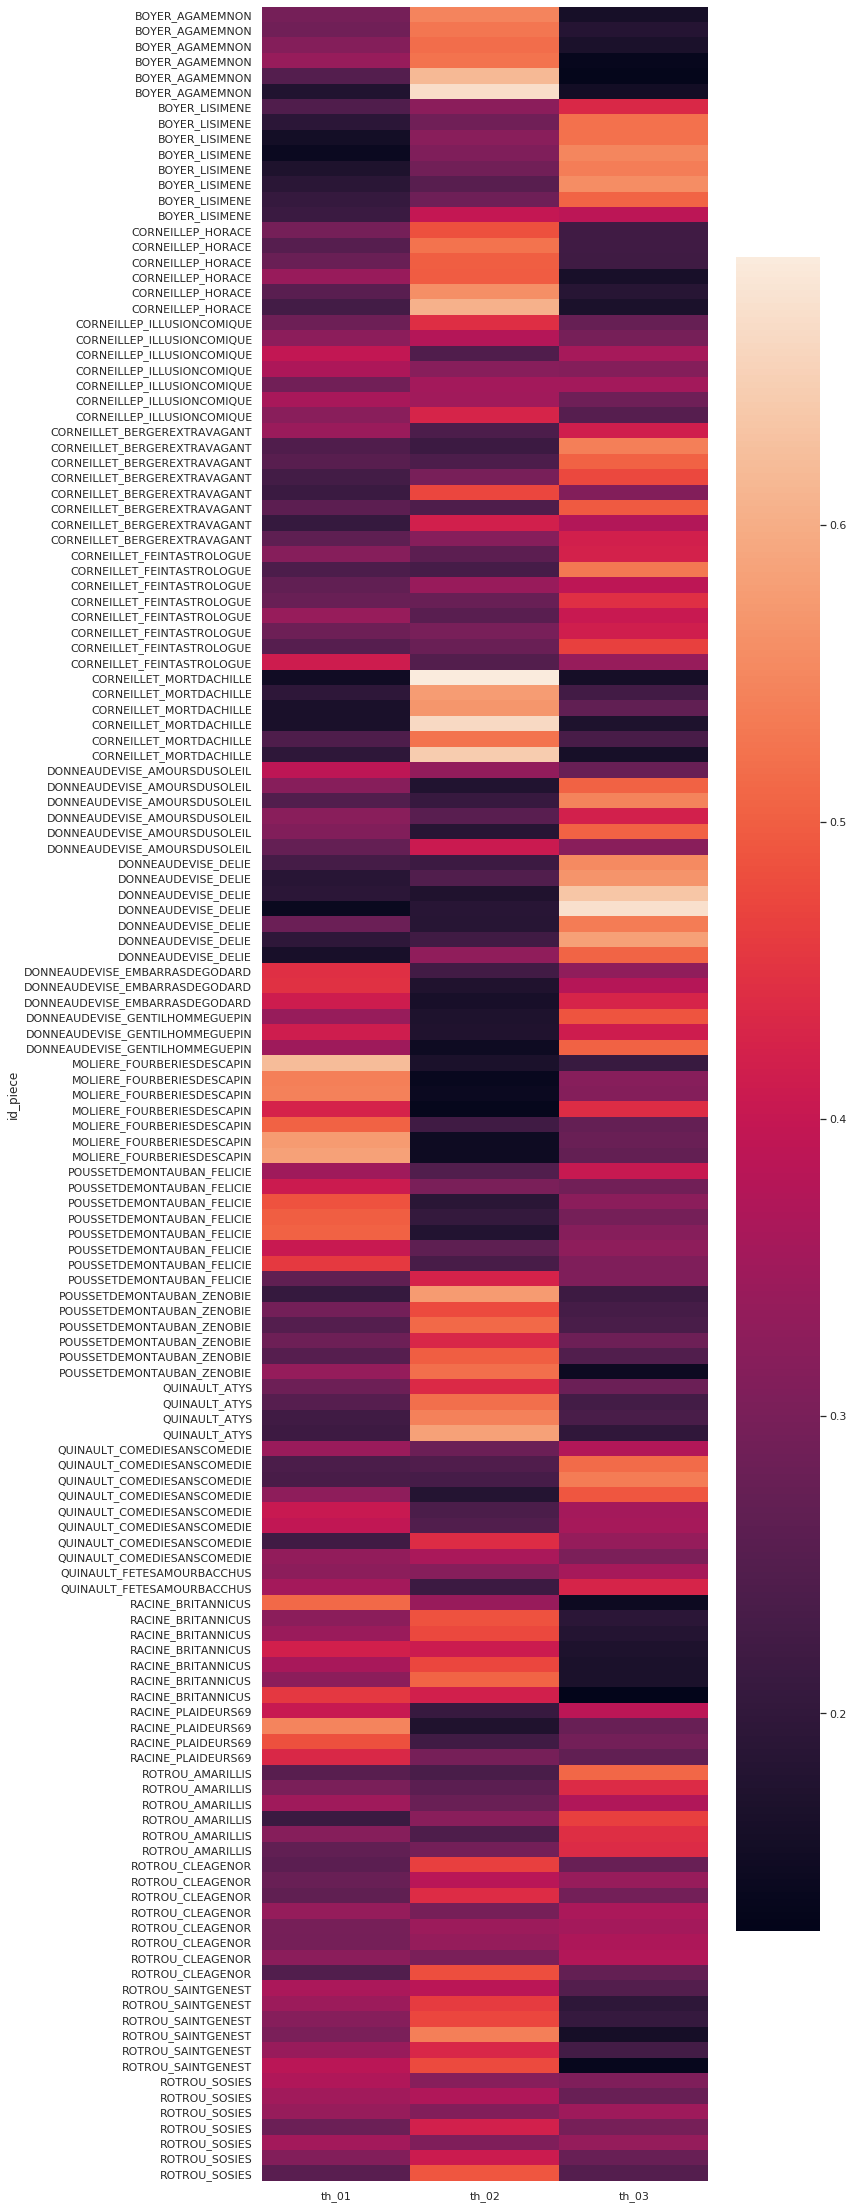

In [0]:
heatmap_df = phc.get_heatmap(lda_model3, 3, corpus, corp, data)
sns.set(rc={'figure.figsize':(10,40)})
sns.heatmap(heatmap_df)

#### Interprétation pour le modèle à 3 sujets
Le modèle parvient à extraire trois thèmes, qui semblent bien correspondre aux trois genres :
- thème 1 : tragédie (lexique qui évoque la grandeur et la noblesse),
- thème 2 : comédie (lexique qui évoque des situations et des relations propres à la bourgeoisie du XVIIe s.)
- thème 3 : pastorale (lexique qui évoque à la fois la campagne et les relations amoureuses).

L'examen des mesures de contributions des thèmes aux pièces soulève quelques questions. *Les Amours du Soleil* (Donneau de Vizé) semblent plutôt relever de la pastorale que de la tragédie (on notera que c'est d'ailleurs le genre retenu 
par l'éditeur). De même, on constate que la *Comédie sans comédie* (Quinault) emprunte plutôt la thématique de la pastorale que de la comédie. À l'inverse, *Cléagénor et Doristée* (Rotrou) ont davantage de traits de la tragédie que de la pastorale. Enfin, deux pastorales témpignent d'un mélange assez marqués des thématiques de la pastorale et de la comédie : *L'Embarras de Godard* (Donneau de Vizé) et *Les Charmes de Félicie* (Pousset de Montauban).

### Modèle à 6 sujets

On relance l'extaction en spécifiant un nombre de sujets égal à 6.



In [0]:
mallet_model6 = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             id2word=id2word,
                                             num_topics=6,
                                             iterations=20,
                                             random_seed=5
                                            )
lda_model6 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(mallet_model6)

#### Termes proposés par le modèle

In [0]:
phc.print_topics(lda_model6)

Thème : th_01
mots : 0.017*"bon" + 0.015*"madame" + 0.012*"homme" + 0.011*"mettre" + 0.011*"tenir" + 0.010*"fille" + 0.009*"coup" + 0.009*"chose" + 0.008*"passer" + 0.008*"attendre"

Thème : th_02
mots : 0.018*"berger" + 0.015*"amant" + 0.014*"Dieu" + 0.013*"doux" + 0.012*"plaire" + 0.011*"bergère" + 0.010*"craindre" + 0.010*"paraître" + 0.010*"flamme" + 0.009*"chercher"

Thème : th_03
mots : 0.013*"connaître" + 0.011*"esprit" + 0.011*"seul" + 0.010*"effet" + 0.008*"apprendre" + 0.008*"attendre" + 0.007*"nom" + 0.007*"naître" + 0.007*"désir" + 0.007*"oser"

Thème : th_04
mots : 0.009*"bien" + 0.008*"faveur" + 0.008*"espoir" + 0.007*"laisser" + 0.007*"toucher" + 0.006*"lieu" + 0.006*"trépas" + 0.006*"vœu" + 0.006*"sortir" + 0.006*"vain"

Thème : th_05
mots : 0.017*"mort" + 0.013*"seigneur" + 0.013*"roi" + 0.012*"gloire" + 0.012*"sang" + 0.011*"main" + 0.009*"crime" + 0.009*"malheur" + 0.008*"madame" + 0.008*"sortir"

Thème : th_06
mots : 0.015*"hymen" + 0.013*"fils" + 0.010*"mère" + 0.0

#### Visualisation LDAvis

In [0]:
vis = pyLDAvis.gensim.prepare(lda_model6, corpus, id2word, sort_topics=False)
vis

/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/fpichenot/app/miniconda3/envs/gensim/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.321890  0.084338       1        1  15.747310
1      0.123967  0.191434       2        1  16.649087
2      0.127444  0.062819       3        1  16.613754
3      0.111941 -0.050860       4        1  15.793694
4     -0.004280 -0.291621       5        1  20.314318
5     -0.037183  0.003890       6        1  14.881838, topic_info=        Term        Freq       Total Category  logprob  loglift
1095     bon  206.000000  206.000000  Default  30.0000  30.0000
1093  berger  296.000000  296.000000  Default  29.0000  29.0000
196    hymen  189.000000  189.000000  Default  28.0000  28.0000
242     mort  319.000000  319.000000  Default  27.0000  27.0000
810     Dieu  192.000000  192.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
405     voix   50.839131  117.345624   Topic6  -5.4427   1.0686
634    temps   52.832823  239.122935   Topic6  -5.4042   0.3952
275   perdre   49.842286  302.316161   Topic6  -5.4625   0.1024
530     fuir   47.848594  146.704104   Topic6  -5.5033   0.7847
421     état   46.851748  115.930800   Topic6  -5.5244   0.9990

[599 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4641      1  0.994531  Britannicu
3         4  0.016998   Cassandre
3         6  0.985894   Cassandre
4021      3  0.988264       Célie
1189      3  1.001268       Diane
...     ...       ...         ...
1275      3  0.988264    étranger
809       2  0.300029        ôter
809       3  0.050005        ôter
809       4  0.560055        ôter
809       6  0.090009        ôter

[1108 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6])

#### Nombre de documents par thèmes, genres et pièces

In [0]:
main_topic_by_doc_6 = phc.get_main_topic_by_doc(lda_model10, corpus, corp, "corpus_1_06")
pd.pivot_table(main_topic_by_doc_6, index=['thème', 'genre', 'id_piece'],
               values=['indice_doc'],
               aggfunc='count')

indice_doc
thème genre     id_piece                                   
th_01 Comédie   CORNEILLEP_ILLUSIONCOMIQUE                3
                CORNEILLET_FEINTASTROLOGUE                6
                DONNEAUDEVISE_EMBARRASDEGODARD            3
                DONNEAUDEVISE_GENTILHOMMEGUEPIN           1
                MOLIERE_FOURBERIESDESCAPIN                7
                QUINAULT_COMEDIESANSCOMEDIE               1
                RACINE_PLAIDEURS69                        4
      Pastorale CORNEILLET_BERGEREXTRAVAGANT              1
th_02 Comédie   DONNEAUDEVISE_GENTILHOMMEGUEPIN           2
      Pastorale BOYER_LISIMENE                            2
                CORNEILLET_BERGEREXTRAVAGANT              3
                DONNEAUDEVISE_DELIE                       7
                QUINAULT_FETESAMOURBACCHUS                2
                ROTROU_AMARILLIS                          3
      Tragédie  DONNEAUDEVISE_AMOURSDUSOLEIL              6
th_03 Comédie   CORNEILLET_FEINTASTROLOGUE                2
                QUINAULT_COMEDIESANSCOMEDIE               4
                ROTROU_SOSIES                             3
      Pastorale CORNEILLET_BERGEREXTRAVAGANT              3
                POUSSETDEMONTAUBAN_FELICIE                7
                ROTROU_AMARILLIS                          3
th_04 Comédie   CORNEILLEP_ILLUSIONCOMIQUE                1
                QUINAULT_COMEDIESANSCOMEDIE               1
                ROTROU_SOSIES                             2
      Pastorale CORNEILLET_BERGEREXTRAVAGANT              1
                ROTROU_CLEAGENOR                          8
      Tragédie  CORNEILLET_MORTDACHILLE                   1
th_05 Comédie   CORNEILLEP_ILLUSIONCOMIQUE                3
                QUINAULT_COMEDIESANSCOMEDIE               1
                ROTROU_SOSIES                             2
      Pastorale POUSSETDEMONTAUBAN_FELICIE                1
      Tragédie  BOYER_AGAMEMNON                           4
                CORNEILLEP_HORACE                         6
                CORNEILLET_MORTDACHILLE                   5
                POUSSETDEMONTAUBAN_ZENOBIE                6
                QUINAULT_ATYS                             4
                RACINE_BRITANNICUS                        7
                ROTROU_SAINTGENEST                        6
th_06 Comédie   QUINAULT_COMEDIESANSCOMEDIE               1
      Pastorale BOYER_LISIMENE                            6
      Tragédie  BOYER_AGAMEMNON                           2

#### Contribution (en pourcentage) de chaque thème à chacune des pièces classées par genre

In [0]:
topics_contrib_by_doc_6 = phc.get_topics_contrib_by_doc(lda_model6, corpus, corp, "corpus_1_06")
pd.pivot_table(topics_contrib_by_doc_6, index=['genre', 'id_piece'],
               columns=['thème'],
               values=['prc_contribution'],
               aggfunc='mean')

prc_contribution             \
thème                                                th_01      th_02   
genre     id_piece                                                      
Comédie   CORNEILLEP_ILLUSIONCOMIQUE             19.070000  14.671429   
          CORNEILLET_FEINTASTROLOGUE             30.185000  14.096250   
          DONNEAUDEVISE_EMBARRASDEGODARD         37.156667  20.330000   
          DONNEAUDEVISE_GENTILHOMMEGUEPIN        23.063333  30.496667   
          MOLIERE_FOURBERIESDESCAPIN             39.444286  15.194286   
          QUINAULT_COMEDIESANSCOMEDIE            15.227500  18.020000   
          RACINE_PLAIDEURS69                     46.217500  16.440000   
          ROTROU_SOSIES                          17.607143   9.995714   
Pastorale BOYER_LISIMENE                          4.621250  26.535000   
          CORNEILLET_BERGEREXTRAVAGANT           13.288750  24.457500   
          DONNEAUDEVISE_DELIE                     5.294286  38.304286   
          POUSSETDEMONTAUBAN_FELICIE             14.506250  10.598750   
          QUINAULT_FETESAMOURBACCHUS             10.330000  42.505000   
          ROTROU_AMARILLIS                        9.473333  22.841667   
          ROTROU_CLEAGENOR                        9.171250  15.320000   
Tragédie  BOYER_AGAMEMNON                         6.856667   5.816667   
          CORNEILLEP_HORACE                      12.711667   5.988333   
          CORNEILLET_MORTDACHILLE                 7.910000   8.830000   
          DONNEAUDEVISE_AMOURSDUSOLEIL            7.230000  34.343333   
          POUSSETDEMONTAUBAN_ZENOBIE             14.066667   5.063333   
          QUINAULT_ATYS                           5.005000  24.662500   
          RACINE_BRITANNICUS                     18.265714   5.737143   
          ROTROU_SAINTGENEST                     15.896667   9.153333   

                                                                            \
thème                                          th_03      th_04      th_05   
genre     id_piece                                                           
Comédie   CORNEILLEP_ILLUSIONCOMIQUE       15.100000  18.075714  18.188571   
          CORNEILLET_FEINTASTROLOGUE       21.427500  12.835000   8.292500   
          DONNEAUDEVISE_EMBARRASDEGODARD    7.983333   9.986667   5.383333   
          DONNEAUDEVISE_GENTILHOMMEGUEPIN  13.290000   9.223333   5.240000   
          MOLIERE_FOURBERIESDESCAPIN        7.714286   9.444286   4.322857   
          QUINAULT_COMEDIESANSCOMEDIE      20.818750  16.805000  15.813750   
          RACINE_PLAIDEURS69                8.062500  10.792500   6.942500   
          ROTROU_SOSIES                    19.067143  21.061429  22.328571   
Pastorale BOYER_LISIMENE                   17.581250  11.207500  10.690000   
          CORNEILLET_BERGEREXTRAVAGANT     21.247500  16.781250  11.082500   
          DONNEAUDEVISE_DELIE              21.112857  13.112857  11.855714   
          POUSSETDEMONTAUBAN_FELICIE       36.807500  12.683750  15.978750   
          QUINAULT_FETESAMOURBACCHUS        7.215000  19.045000  11.395000   
          ROTROU_AMARILLIS                 22.136667  20.720000   9.373333   
          ROTROU_CLEAGENOR                 15.965000  28.711250  18.021250   
Tragédie  BOYER_AGAMEMNON                  10.281667  10.980000  34.926667   
          CORNEILLEP_HORACE                11.276667  15.411667  39.173333   
          CORNEILLET_MORTDACHILLE           7.720000  25.070000  35.936667   
          DONNEAUDEVISE_AMOURSDUSOLEIL     18.151667  15.978333  13.796667   
          POUSSETDEMONTAUBAN_ZENOBIE       10.875000   9.896667  48.580000   
          QUINAULT_ATYS                    10.075000  14.670000  34.275000   
          RACINE_BRITANNICUS               15.794286  12.154286  35.785714   
          ROTROU_SAINTGENEST               16.058333  17.251667  31.996667   

                                                      
thème                                          th_06  
genr

#### Visualisation (carte de chaleur) de la contribution de chaque thème à chacune des pièces

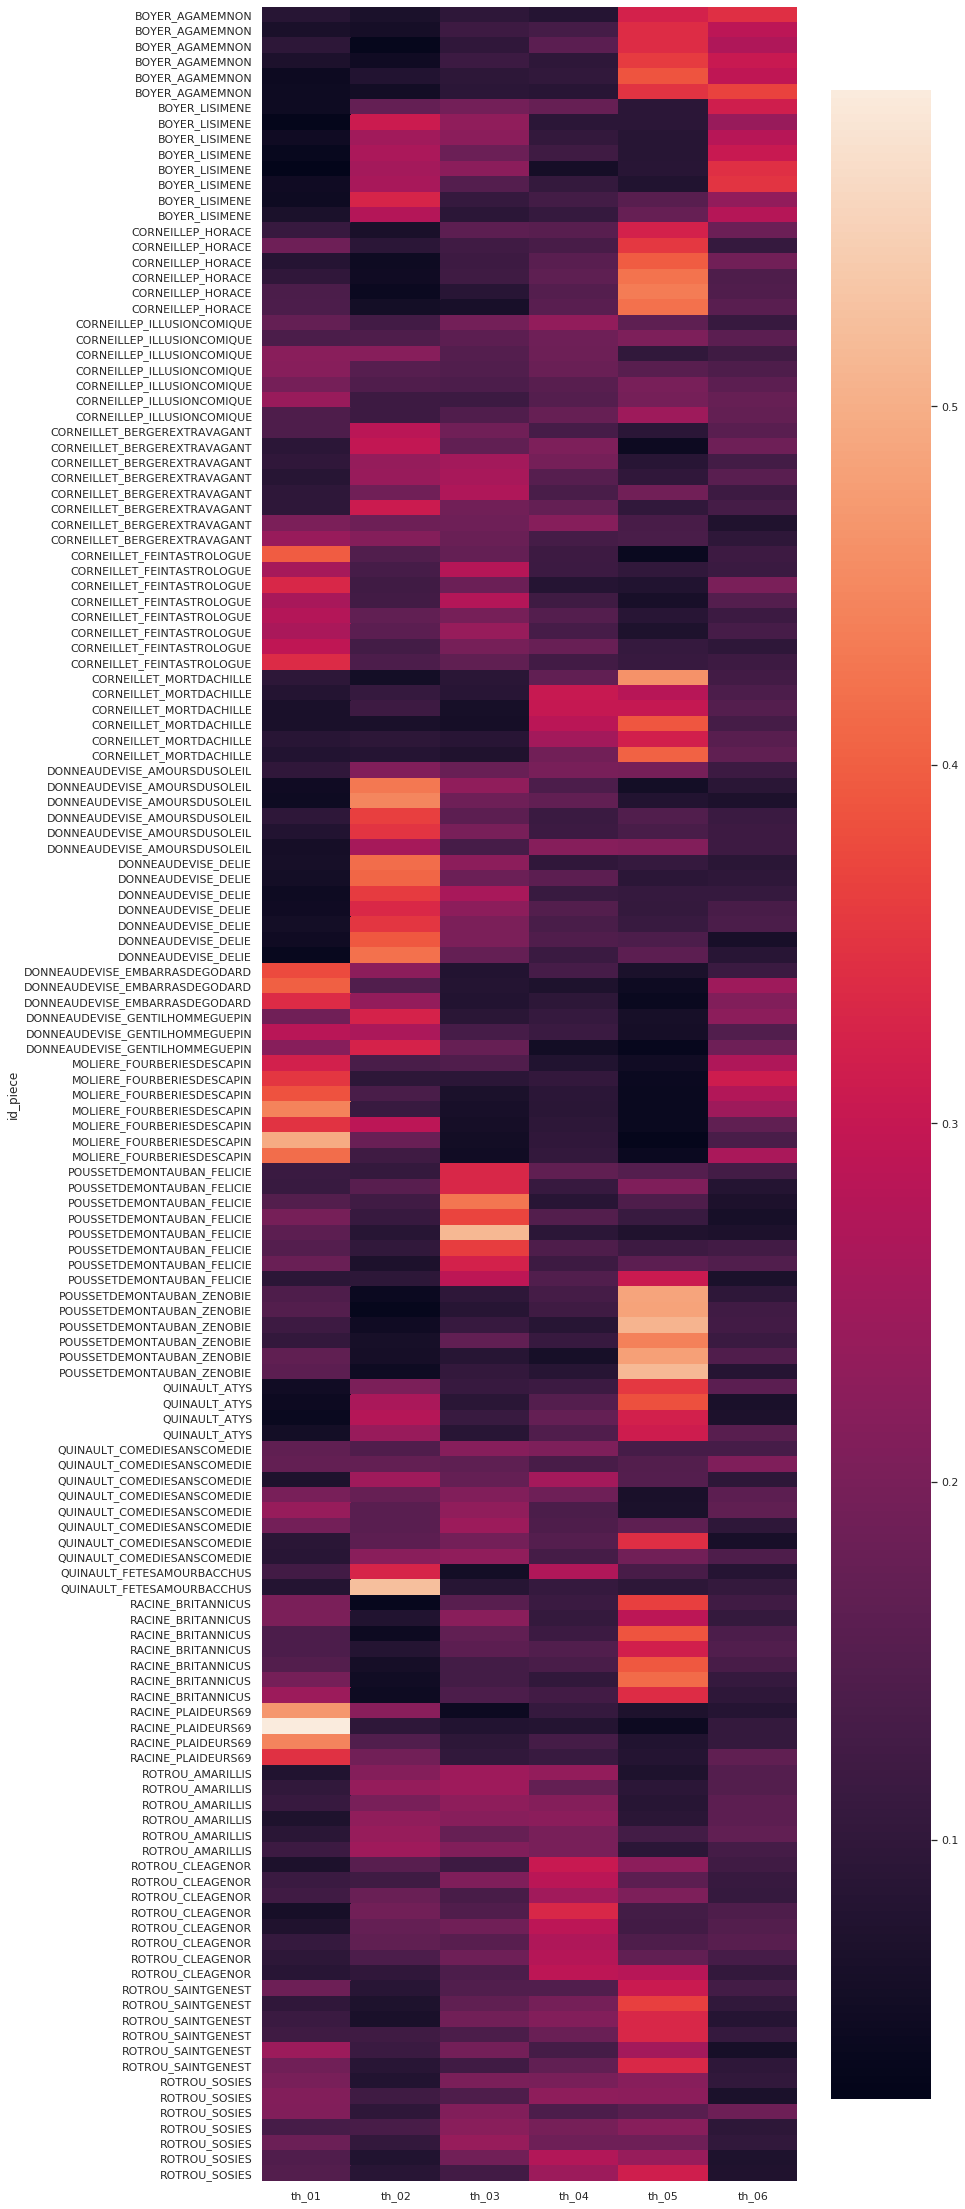

In [0]:
heatmap_df = phc.get_heatmap(lda_model6, 6, corpus, corp, data)
sns.set(rc={'figure.figsize':(12,40)})
sns.heatmap(heatmap_df)

#### Interprétation pour le modèle à 6 sujets

S'il est difficile de relier précisément les sujets obtenus à l'un ou l'autre des trois genres, le modèle à six sujets permet en revanche de préciser l'analyse pour les pièces ambivalentes :
- le classement des *Amours du Soleil* (Donneau de Vizé) en tant que pastorale plutôt que tragédie est confirmé,
- le doute concernant *L'Embarras de Godard* (Donneau de Vizé) semble levé (la pièce tient bien de la comédie)
- *Les Charmes de Félicie* (Pousset de Montauban) se caractérisent bien par le mélange des thématiques de la pastorale et de la comédie.
- *Cléagénor et Doristée* (Rotrou) apparaissent bien comme un cas particulier : le modèle renvoie une thématique quasiment propore à cette pièce (thématique d'une relation amoureuse contrariée, dans un cadre difficile à déterminer (ni la ville, ni la cour, ni la campagne) ?)

Le modèle semble toutefois mal fonctionner pour la *Comédie sans comédie* (Quinault), qu'on ne parvient pas à classer.